This notebook uses below given notebooks to make predictions.

1. LB 0.468 https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-infer-3
2. LB 0.474 https://www.kaggle.com/maunish/clrp-roberta-svm

# Imports

In [1]:
import os
import gc
import sys
import cv2
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

from transformers import (AutoModel, AutoTokenizer, 
                          AutoModelForSequenceClassification)
from transformers import (RobertaTokenizer, RobertaModel)

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff


from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

# Data analysys

In [2]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

target = train_data['target'].to_numpy()
target_normed = (target - np.mean(target))/np.var(target)
bins = train_data.bins.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [3]:
pd.cut(train_data['target'],bins=num_bins)

0       (-0.533, -0.0845]
1       (-0.533, -0.0845]
2        (-0.982, -0.533]
3        (-1.431, -0.982]
4        (-0.0845, 0.364]
              ...        
2829       (1.262, 1.711]
2830     (-0.0845, 0.364]
2831     (-0.0845, 0.364]
2832    (-0.533, -0.0845]
2833     (-0.0845, 0.364]
Name: target, Length: 2834, dtype: category
Categories (12, interval[float64]): [(-3.682, -3.227] < (-3.227, -2.778] < (-2.778, -2.329] < (-2.329, -1.88] ... (-0.0845, 0.364] < (0.364, 0.813] < (0.813, 1.262] < (1.262, 1.711]]

(array([ 55., 120., 280., 402., 490., 563., 458., 312., 123.,  31.]),
 array([-3.67626777, -3.13750201, -2.59873625, -2.05997049, -1.52120473,
        -0.98243897, -0.44367321,  0.09509255,  0.63385831,  1.17262407,
         1.71138983]),
 <BarContainer object of 10 artists>)

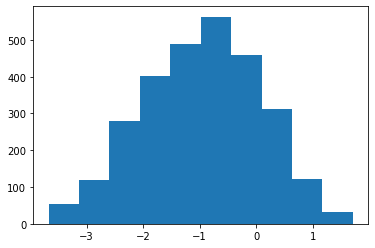

In [4]:
plt.hist(target, bins=10)

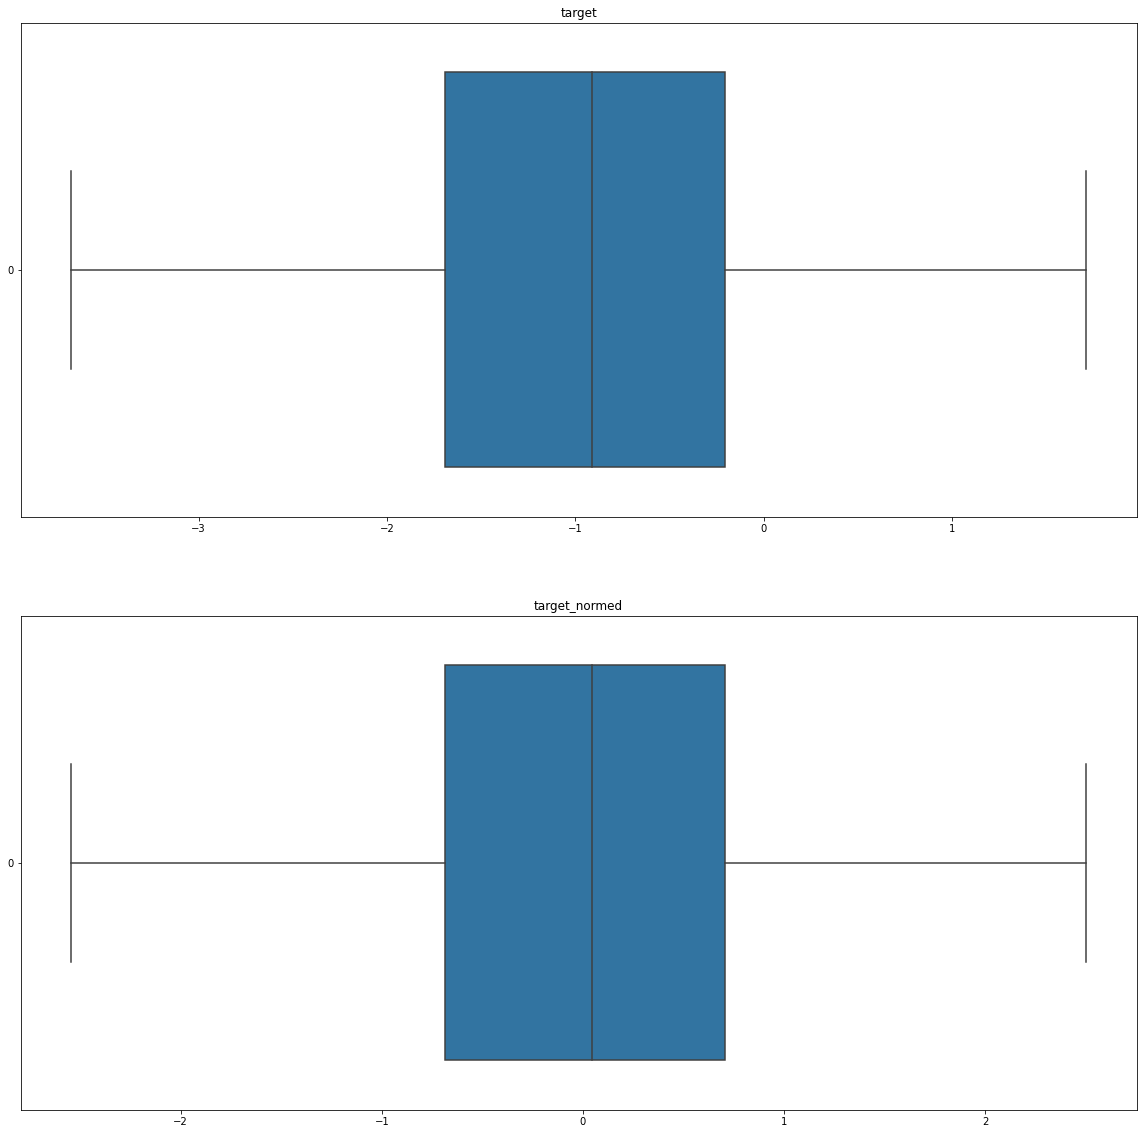

In [5]:
ig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
for i, (data, data_name) in enumerate(zip([target, target_normed], ['target', 'target_normed'])):
    sns.boxplot(data=data, orient='h', ax = ax[i])
    ax[i].set_title(data_name)

In [6]:
train_data

,id,url_legal,license,excerpt,target,standard_error,bins
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8
...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,8
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,8
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,7


In [7]:
test_data

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [8]:
train_data.drop(['target', 'url_legal', 'license', 'standard_error', 'bins'], 1)

,id,excerpt
0,c12129c31,When the young people returned to the ballroom...
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh..."
2,b69ac6792,"As Roger had predicted, the snow departed as q..."
3,dd1000b26,And outside before the palace a great garden w...
4,37c1b32fb,Once upon a time there were Three Bears who li...
...,...,...
2829,25ca8f498,When you think of dinosaurs and where they liv...
2830,2c26db523,So what is a solid? Solids are usually hard be...
2831,cd19e2350,The second state of matter we will discuss is ...
2832,15e2e9e7a,Solids are shapes that you can actually touch....


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(['target', 'url_legal', 'license', 'standard_error', 'bins'], 1),
    target_normed, test_size=0.33, random_state=42)

In [10]:
X_train

,id,excerpt
2383,a16f5d2c6,Tom and his crowd looked down the path and saw...
489,14112c6ee,"The Miranda warning, which can also be referre..."
2227,9635671b4,"They have kangaroo rats, and dogs of the jacka..."
1417,b5944cff3,"No boy can afford to neglect his work, and, wi..."
690,5cd839366,We know these motor representations are stored...
...,...,...
1638,240b89006,The steam is supplied by two circular return t...
1095,243f9f286,Living things are different from things that a...
1130,e044e1347,"I'd always longed for adventures. You see, my ..."
1294,7d016018e,In these times one dread lies heavy on heart a...


In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, target, tokenizer):
        super(Dataset).__init__()
        self.data = [(row[1]['id'], row[1]['excerpt']) for row in data.iterrows()]
        self.target = target
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.data[idx][1],return_tensors='pt',
                                max_length=config['max_len'],
                                padding='max_length',truncation=True)
        return self.data[idx][0], encode, self.target
#         return data[idx]['id'], data[idx]['excerpt'], target[idx]

In [12]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset = CustomDataset(X_train, y_train, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# Model training

In [15]:
config = {
    'batch_size':128,
    'max_len':256,
    'nfolds':5,
    'seed':42,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

cuda


In [14]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.excerpt = df['excerpt'].to_numpy()
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],return_tensors='pt',
                                max_length=config['max_len'],
                                padding='max_length',truncation=True)
        return encode
    
    def __len__(self):
        return len(self.excerpt)

In [143]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [177]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base') 
        self.head = AttentionHead(768,768,1)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.head.out_features,1)

    def forward(self,**xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        x = self.droput(x)
        x = self.linear(x)
        return x

In [175]:
model = Model()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
epochs = 1

def train(
    model, opt, loss_fn,
    train_loader, test_loader,
    epochs
):
    for epoch in range(epochs):
        for ids, X_batch, y_batch in train_loader:
            opt.zero_grad()
            
            y_batch = torch.Tensor(y_batch.float())
            
            inputs = {key:val.reshape(val.shape[0],-1) for key,val in X_batch.items()}
            print (inputs)
            y_pred = model.forward(**inputs)
            loss = loss_fn(y_pred, y_batch)
            
            loss.baskward()
            opt.step()
        
        for ids, X_batch, y_batch in test_loader:

            y_batch = torch.Tensor(y_batch.float())
            
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            print (loss)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [176]:
train(model, optimizer, loss_fn,
    train_loader, test_loader,
    epochs)

{'input_ids': tensor([[    0, 15691,     8,  ...,     1,     1,     1],
        [    0,   133, 16002,  ...,     1,     1,     1],
        [    0,  1213,    33,  ...,     1,     1,     1],
        ...,
        [    0,   133, 24883,  ...,     1,     1,     1],
        [    0,   100,   109,  ...,     1,     1,     1],
        [    0,  1185,   189,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


KeyboardInterrupt: 

# Inference

In [12]:
def get_embeddings(df,path,plot_losses=True, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
            
    model = Model()
#     model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    print ('asd')
    ds = CLRPDataset(df,tokenizer)
    dl = DataLoader(ds,
                  batch_size = config["batch_size"],
                  shuffle=False,
                  num_workers = 4,
                  pin_memory=True,
                  drop_last=False
                 )
        
    embeddings = list()
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.detach().cpu().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)

In [ ]:
train_embeddings1 =  get_embeddings(train_data,'../input/clr-roberta/model0/model0.bin')
test_embeddings1 = get_embeddings(test_data,'../input/clr-roberta/model0/model0.bin')

cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_embeddings1 =  get_embeddings(train_data,'../input/clr-roberta/model0/model0.bin')
test_embeddings1 = get_embeddings(test_data,'../input/clr-roberta/model0/model0.bin')

train_embeddings2 =  get_embeddings(train_data,'../input/clr-roberta/model1/model1.bin')
test_embeddings2 = get_embeddings(test_data,'../input/clr-roberta/model1/model1.bin')

train_embeddings3 =  get_embeddings(train_data,'../input/clr-roberta/model2/model2.bin')
test_embeddings3 = get_embeddings(test_data,'../input/clr-roberta/model2/model2.bin')

train_embeddings4 =  get_embeddings(train_data,'../input/clr-roberta/model3/model3.bin')
test_embeddings4 = get_embeddings(test_data,'../input/clr-roberta/model3/model3.bin')

train_embeddings5 =  get_embeddings(train_data,'../input/clr-roberta/model4/model4.bin')
test_embeddings5 = get_embeddings(test_data,'../input/clr-roberta/model4/model4.bin')

cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## svm

In [9]:
def get_preds_svm(X,y,X_test,bins=bins,nfolds=5,C=10,kernel='rbf'):
    scores = list()
    preds = np.zeros((X_test.shape[0]))
    
    kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
    for k, (train_idx,valid_idx) in enumerate(kfold.split(X,bins)):
        model = SVR(C=C,kernel=kernel,gamma='auto')
        X_train,y_train = X[train_idx], y[train_idx]
        X_valid,y_valid = X[valid_idx], y[valid_idx]
        
        model.fit(X_train,y_train)
        prediction = model.predict(X_valid)
        score = rmse_score(prediction,y_valid)
        print(f'Fold {k} , rmse score: {score}')
        scores.append(score)
        preds += model.predict(X_test)
        
    print("mean rmse",np.mean(scores))
    return np.array(preds)/nfolds

In [10]:
svm_preds1 = get_preds_svm(train_embeddings1,target,test_embeddings1)
svm_preds2 = get_preds_svm(train_embeddings2,target,test_embeddings2)
svm_preds3 = get_preds_svm(train_embeddings3,target,test_embeddings3)
svm_preds4 = get_preds_svm(train_embeddings4,target,test_embeddings4)
svm_preds5 = get_preds_svm(train_embeddings5,target,test_embeddings5)

Fold 0 , rmse score: 0.47727497027807975
Fold 1 , rmse score: 0.2578880377682382
Fold 2 , rmse score: 0.2541082644861084
Fold 3 , rmse score: 0.24054325983483563
Fold 4 , rmse score: 0.2551938404392728
mean rmse 0.297001674561307
Fold 0 , rmse score: 0.2425235616562364
Fold 1 , rmse score: 0.5016510069411838
Fold 2 , rmse score: 0.23847703706225037
Fold 3 , rmse score: 0.23492862892763802
Fold 4 , rmse score: 0.24930508381707772
mean rmse 0.2933770636808773
Fold 0 , rmse score: 0.3908661185328736
Fold 1 , rmse score: 0.4135395361379846
Fold 2 , rmse score: 0.4895740066653232
Fold 3 , rmse score: 0.3756053322147557
Fold 4 , rmse score: 0.4008420352519307
mean rmse 0.4140854057605735
Fold 0 , rmse score: 0.2878583154409844
Fold 1 , rmse score: 0.27540087825175247
Fold 2 , rmse score: 0.2809937810667762
Fold 3 , rmse score: 0.45763179894261946
Fold 4 , rmse score: 0.2852643347020617
mean rmse 0.31742982168083883
Fold 0 , rmse score: 0.4013671778501825
Fold 1 , rmse score: 0.42662641489545

In [11]:
svm_preds = (svm_preds1 + svm_preds2 + svm_preds3 + svm_preds4 + svm_preds5)/5

**The second notebook**

In [12]:
%matplotlib inline
from glob import glob
import os
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import gc
gc.enable()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import (
    Dataset, DataLoader, 
    SequentialSampler, RandomSampler
)
from transformers import RobertaConfig
from transformers import (
    get_cosine_schedule_with_warmup, 
    get_cosine_with_hard_restarts_schedule_with_warmup
)
from transformers import RobertaTokenizer
from transformers import RobertaModel
from IPython.display import clear_output
from tqdm import tqdm, trange

In [14]:
def convert_examples_to_features(data, tokenizer, max_len, is_test=False):
    data = data.replace('\n', '')
    tok = tokenizer.encode_plus(
        data, 
        max_length=max_len, 
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True
    )
    curr_sent = {}
    padding_length = max_len - len(tok['input_ids'])
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + \
        ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + \
        ([0] * padding_length)
    return curr_sent

In [15]:
class DatasetRetriever(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.values.tolist()
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:
            excerpt, label = self.excerpts[item], self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, 
                self.max_len, self.is_test
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'token_type_ids':torch.tensor(features['token_type_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.double),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, 
                self.max_len, self.is_test
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'token_type_ids':torch.tensor(features['token_type_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

In [16]:
class CommonLitModel(nn.Module):
    def __init__(
        self, 
        model_name, 
        config,  
        multisample_dropout=False,
        output_hidden_states=False
    ):
        super(CommonLitModel, self).__init__()
        self.config = config
        self.roberta = RobertaModel.from_pretrained(
            model_name, 
            output_hidden_states=output_hidden_states
        )
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        if multisample_dropout:
            self.dropouts = nn.ModuleList([
                nn.Dropout(0.5) for _ in range(5)
            ])
        else:
            self.dropouts = nn.ModuleList([nn.Dropout(0.3)])
        self.regressor = nn.Linear(config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        self._init_weights(self.regressor)
 
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
 
    def forward(
        self, 
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None
    ):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        sequence_output = outputs[1]
        sequence_output = self.layer_norm(sequence_output)
 
        # multi-sample dropout
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                logits = self.regressor(dropout(sequence_output))
            else:
                logits += self.regressor(dropout(sequence_output))
        
        logits /= len(self.dropouts)
 
        # calculate loss
        loss = None
        if labels is not None:
            loss_fn = torch.nn.MSELoss()
            logits = logits.view(-1).to(labels.dtype)
            loss = torch.sqrt(loss_fn(logits, labels.view(-1)))
        
        output = (logits,) + outputs[1:]
        return ((loss,) + output) if loss is not None else output

In [17]:
def make_model(model_name, num_labels=1):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    config = RobertaConfig.from_pretrained(model_name)
    config.update({'num_labels':num_labels})
    model = CommonLitModel(model_name, config=config)
    return model, tokenizer

def make_loader(
    data, 
    tokenizer, 
    max_len,
    batch_size,
):
    
    test_dataset = DatasetRetriever(data, tokenizer, max_len, is_test=True)
    test_sampler = SequentialSampler(test_dataset)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size // 2, 
        sampler=test_sampler, 
        pin_memory=False, 
        drop_last=False, 
        num_workers=0
    )

    return test_loader

In [18]:
class Evaluator:
    def __init__(self, model, scalar=None):
        self.model = model
        self.scalar = scalar

    def evaluate(self, data_loader, tokenizer):
        preds = []
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(data_loader):
                input_ids, attention_mask, token_type_ids = batch_data['input_ids'], \
                    batch_data['attention_mask'], batch_data['token_type_ids']
                input_ids, attention_mask, token_type_ids = input_ids.cuda(), \
                    attention_mask.cuda(), token_type_ids.cuda()
                
                if self.scalar is not None:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids
                        )
                else:
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids
                    )
                
                logits = outputs[0].detach().cpu().numpy().squeeze().tolist()
                preds += logits
        return preds

In [19]:
def config(fold, model_name, load_model_path):
    torch.manual_seed(2021)
    torch.cuda.manual_seed(2021)
    torch.cuda.manual_seed_all(2021)
    
    max_len = 250
    batch_size = 8

    model, tokenizer = make_model(
        model_name=model_name, 
        num_labels=1
    )
    model.load_state_dict(
        torch.load(f'{load_model_path}/model{fold}.bin')
    )
    test_loader = make_loader(
        test, tokenizer, max_len=max_len,
        batch_size=batch_size
    )

    if torch.cuda.device_count() >= 1:
        print('Model pushed to {} GPU(s), type {}.'.format(
            torch.cuda.device_count(), 
            torch.cuda.get_device_name(0))
        )
        model = model.cuda() 
    else:
        raise ValueError('CPU training is not supported')

    # scaler = torch.cuda.amp.GradScaler()
    scaler = None
    return (
        model, tokenizer, 
        test_loader, scaler
    )

In [20]:
def run(fold=0, model_name=None, load_model_path=None):
    model, tokenizer, \
        test_loader, scaler = config(fold, model_name, load_model_path)
    
    import time

    evaluator = Evaluator(model, scaler)

    test_time_list = []

    torch.cuda.synchronize()
    tic1 = time.time()

    preds = evaluator.evaluate(test_loader, tokenizer)

    torch.cuda.synchronize()
    tic2 = time.time() 
    test_time_list.append(tic2 - tic1)
    
    del model, tokenizer, test_loader, scaler
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds

In [21]:
%%time

import pandas as pd
import numpy as np

train = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

pred_df1 = pd.DataFrame()
pred_df2 = pd.DataFrame()
pred_df3 = pd.DataFrame()
for fold in tqdm(range(5)):
    pred_df1[f'fold{fold}'] = run(fold, '../input/roberta-base/', '../input/commonlit-roberta-base-i/')
    pred_df2[f'fold{fold+5}'] = run(fold, '../input/robertalarge/', '../input/roberta-large-itptfit/')
    pred_df3[f'fold{fold+10}'] = run(fold, '../input/robertalarge/', '../input/commonlit-roberta-large-ii/')

  0%|          | 0/5 [00:00<?, ?it/s]

Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


 20%|██        | 1/5 [01:05<04:22, 65.51s/it]

Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


 40%|████      | 2/5 [01:56<02:50, 56.96s/it]

Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


 60%|██████    | 3/5 [02:46<01:47, 53.78s/it]

Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


 80%|████████  | 4/5 [03:37<00:52, 52.68s/it]

Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.
Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


100%|██████████| 5/5 [04:27<00:00, 53.51s/it]

CPU times: user 1min 30s, sys: 17.6 s, total: 1min 48s
Wall time: 4min 27s


In [22]:
sample['target'] = (pred_df2.mean(axis=1)*0.35) + (pred_df1.mean(axis=1)*0.20) + (pred_df3.mean(axis=1) * 0.15) + (svm_preds * 0.30)
sample.to_csv('submission.csv', index=False)